In [13]:
!pip install pyAudioAnalysis
!pip install pydub
!pip install plotly
!pip install ffprobe-python
!pip install avprobe-python
!pip install eyed3
!pip install ntpath
!pip install shutil

ERROR: Could not find a version that satisfies the requirement avprobe-python (from versions: none)
ERROR: No matching distribution found for avprobe-python


     -------------------------------------- 246.1/246.1 kB 3.8 MB/s eta 0:00:00
     ------------------------------------- 211.5/211.5 kB 13.4 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement ntpath (from versions: none)
ERROR: No matching distribution found for ntpath
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [62]:
from pydub import AudioSegment
import numpy as np
from scipy.io import wavfile
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import plotly
import os
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import MidTermFeatures
import matplotlib.pyplot as plt

WINDOW_SAMPLING_RATE_RATIO = 0.1
STEP_SAMPLING_RATE_RATIO = 0.08

MID_FEATURES_WINDOW = 4
MID_FEATURES_STEP = 2

# read the 8 mp3 files in the data folder
def read_audio_files():
    files_data = []
    for i in range(8):
        sampling_rate, signal = audioBasicIO.read_audio_file("./data/"+str(i)+".mp3")
        mono_signal = audioBasicIO.stereo_to_mono(signal)
        files_data.append([sampling_rate, mono_signal])
    return files_data

# extract short term features from a signal
# returns (short_features, short_features_labels)
def extract_short_term_features(sampling_rate, signal):
    window = sampling_rate * WINDOW_SAMPLING_RATE_RATIO
    step = sampling_rate * STEP_SAMPLING_RATE_RATIO
    return ShortTermFeatures.feature_extraction(signal, sampling_rate, window, step)

# extract mid term features from a signal
# returns (mid_features, short_features, mid_features_labels)
def extract_mid_term_features(sampling_rate, signal):
    mid_window = sampling_rate * MID_FEATURES_WINDOW
    mid_step = sampling_rate * MID_FEATURES_STEP

    window = sampling_rate * WINDOW_SAMPLING_RATE_RATIO
    step = sampling_rate * STEP_SAMPLING_RATE_RATIO

    return MidTermFeatures.mid_feature_extraction(signal, sampling_rate, mid_window, mid_step, window, step)

# extract global attributes of an entire track
def extract_global_attributes(sampling_rate, signal):
    mid_features, short_features, mid_features_labels = extract_mid_term_features(sampling_rate, signal)
    global_attributes = []
    global_attributes_labels = []
    for i in range(len(mid_features)):
        global_attributes.append(np.mean(mid_features[i,:]))
        global_attributes_labels.append(mid_features_labels[i] + "_GLOBAL_MEAN")

        global_attributes.append(np.std(mid_features[i,:]))
        global_attributes_labels.append(mid_features_labels[i] + "_GLOBAL_STD")
    return global_attributes, global_attributes_labels
    

In [4]:
# read files data
files_data = read_audio_files()

In [44]:
# extract features
files_features_data = []
for file_index, [sr, signal] in enumerate(files_data):
    mid_term_features, short_term_features, mid_term_feat_labels = extract_mid_term_features(sr, signal)
    files_features_data.append([mid_term_features, short_term_features, mid_term_feat_labels])

# converting to numpy array
file_features_data = np.asarray(files_features_data, dtype="object")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [58]:
# extract global attributes (same amount, whatever the length of the clip)
global_files_attributes = []
for file_index, [sr, signal] in enumerate(files_data):
    attributes, attributes_labels = extract_global_attributes(sr, signal)
    global_files_attributes.append([attributes, attributes_labels])
global_files_attributes = np.asarray(global_files_attributes, dtype="object")

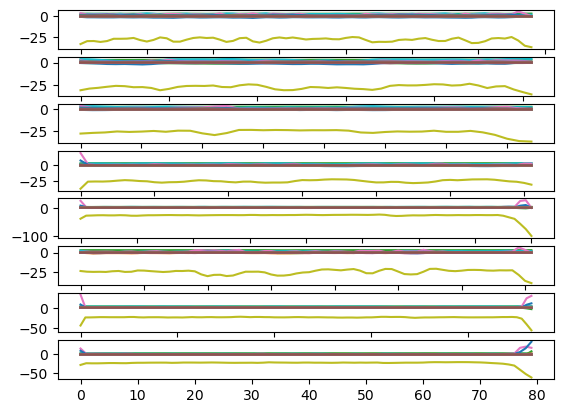

In [63]:
# plot the features of all of the 8 files
fig, axs = plt.subplots(8)

for file_index, [mid_term_features, short_term_features, mid_term_feat_labels] in enumerate(file_features_data):
    for feature_index in range(len(mid_term_features)):
        axs[file_index].plot(mid_term_features[feature_index,:])

In [138]:
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr

def select_feature_subset(features, labels_to_select):
    return [features[0][i] for i in range(len(features[0])) if (features[1][i] in labels_to_select)]

def select_and_flatten_features(features, labels_to_select):
    feats = select_feature_subset(features, labels_to_select)
    return np.asarray(feats[0], dtype="object").flatten();

# compute the euclidean distance between one of the file features and all the others
def calculate_distances(features, base_index, selected_features):
    reference_features = select_and_flatten_features(features[base_index], selected_features)

    distances = []
    for i in range(len(features)):
        other = select_and_flatten_features(features[i], selected_features)
        distances.append((i, euclidean(reference_features, other)))
    return distances

def get_ranking_score(distances):
    CORRECT_RANKING = [0,1,2,3,4,5,6,7]

    ordered_distances = sorted(distances, key=lambda x: x[1])
    ranked_indices = [index for index, _ in ordered_distances]
    spearman_correlation, p_value = spearmanr(CORRECT_RANKING, ranked_indices)

    return spearman_correlation, ranked_indices, ordered_distances

print(select_feature_subset(global_files_attributes[0],["zcr_mean_global_mean"]))

[0.028202367839773885]


In [142]:
from scipy.stats import spearmanr

features_list = global_files_attributes[0][1]

distances = calculate_distances(global_files_attributes, 0, features_list)

spearman_correlation, ranked_indices, ordered_distances = get_ranking_score(distances)

print(spearman_correlation)
print(ranked_indices)
print(ordered_distances)

0.8333333333333335
[0, 1, 4, 2, 6, 3, 5, 7]
[(0, 0.0), (1, 0.00032074957144660743), (4, 0.0008328064491264567), (2, 0.00465200101500084), (6, 0.004774832036247994), (3, 0.005810233387706063), (5, 0.025718826545811525), (7, 0.03482320485244657)]
